In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
import os

# For processing
import math
import random
import datetime as dt

# Libraries for model training
!pip install scikit-learn
!pip install tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("CAC40_stocks_2010_2021.csv", parse_dates=['Date'])
df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
0,TechnipFMC,FTI,29.855000,29.075001,29.075001,29.615000,1908400.0,2010-01-04
1,TechnipFMC,FTI,30.270000,29.555000,29.610001,30.125000,2206600.0,2010-01-05
2,TechnipFMC,FTI,30.305000,29.434999,30.040001,30.264999,2724200.0,2010-01-06
3,TechnipFMC,FTI,30.219999,29.715000,30.155001,29.915001,2581000.0,2010-01-07
4,TechnipFMC,FTI,30.500000,29.625000,29.830000,30.450001,3280400.0,2010-01-08


In [3]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81735 entries, 0 to 81734
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CompanyName  81735 non-null  object        
 1   StockName    81735 non-null  object        
 2   High         81735 non-null  float64       
 3   Low          81735 non-null  float64       
 4   Open         81735 non-null  float64       
 5   Close        81735 non-null  float64       
 6   Volume       81735 non-null  float64       
 7   Date         81735 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 5.0+ MB


In [11]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['CompanyName'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

# Selecting any random company out of our 'CompanyName' column
company_name = random.choice(df['CompanyName'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

specific_df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
14791,Veolia,VIE,25.500000,19.500000,21.500000,23.410000,1608000.0,2019-10-03
14792,Veolia,VIE,24.250000,22.010000,23.000000,23.120001,323200.0,2019-10-04
14793,Veolia,VIE,23.840000,21.040001,23.090000,21.740000,449200.0,2019-10-07
14794,Veolia,VIE,22.445000,20.700001,21.740000,21.049999,301300.0,2019-10-08
14795,Veolia,VIE,21.809999,18.200001,21.200001,19.110001,710200.0,2019-10-09


Visualization

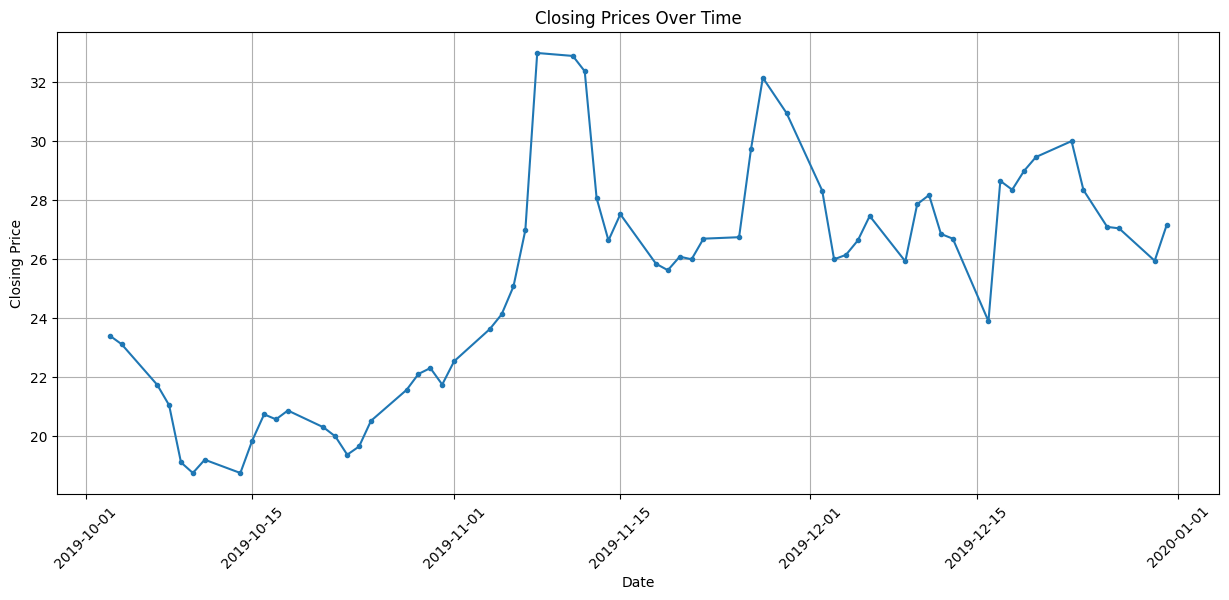

In [14]:
import matplotlib.pyplot as plt
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()